In [1]:
!pwd

/home/home1/xw176/work/Domain_Adaptation/configs/xh.test_diff


In [1]:
import os
import sys
sys.path.append(os.getcwd())
import torch
import argparse
from model.deeplab import *
from tqdm import tqdm
import json
from utils.metrics import Evaluator
from data import spacenet
from common import config
from torch.utils.data import DataLoader
import numpy as np
import cv2
import torchvision
import matplotlib.pyplot as plt

In [2]:
# source domain model
model_path_s = '/home/home1/xw176/work/Domain_Adaptation/configs/mobilenet.baseline/xh.deeplab.mobilenet.shanghai.n\
/train_log/models/epoch228.pth'
# target domain model
model_path_t = '/home/home1/xw176/work/Domain_Adaptation/configs/mobilenet.baseline/xh.deeplab.mobilenet.khartoum.n\
/train_log/models/epoch701.pth'

cuda = True
# bn = False
# save_path = None
# save_batch = 0

In [3]:
source = 'Shanghai'
target = 'Khartoum'
batch_size = 1
source_set = spacenet.Spacenet(city=source, split='test', img_root=config.img_root)
source_loader = DataLoader(source_set, batch_size=batch_size, shuffle=True, num_workers=2)
target_set = spacenet.Spacenet(city=target, split='test', img_root=config.img_root)
target_loader = DataLoader(target_set, batch_size=batch_size, shuffle=True, num_workers=2)


model_s = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=config.freeze_bn)
model_t = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=config.freeze_bn)

if cuda:
    checkpoint_s = torch.load(model_path_s)
    checkpoint_t = torch.load(model_path_t)
else:
    checkpoint_s = torch.load(model_path_s, map_location=torch.device('cpu'))
    checkpoint_t = torch.load(model_path_t, map_location=torch.device('cpu'))
    
model_s.load_state_dict(checkpoint_s)
model_t.load_state_dict(checkpoint_t)

# evaluator = Evaluator(2)
if cuda:
    model_s = model_s.cuda()
    model_t = model_t.cuda()

Found 646 test images
Found 180 test images


In [4]:
model_s.eval()
model_t.eval()
sample_s = iter(source_loader).next()
sample_t = iter(target_loader).next()

image_s, target_s = sample_s['image'], sample_s['label']
image_t, target_t = sample_t['image'], sample_t['label']

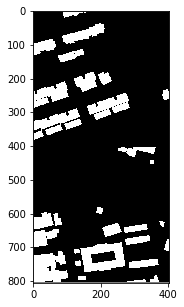

In [5]:
plt.figure(figsize=(5,5))
batch_s1_t2 = torchvision.utils.make_grid(torch.cat((target_s, target_t), 0).unsqueeze(1), batch_size, pad_value=0.5).numpy().transpose((1,2,0))
plt.imshow(batch_s1_t2)
plt.show()

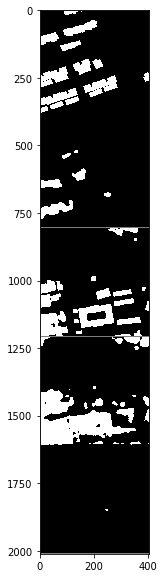

In [13]:
if cuda:
    image_s, target_s = image_s.cuda(), target_s.cuda()
    image_t, target_t = image_t.cuda(), target_t.cuda()
    
with torch.no_grad():
    output_m_s_i_s, f0_m_s_i_s, f1_m_s_i_s, f2_m_s_i_s, f3_m_s_i_s, high_m_s_i_s= model_s(image_s)
    output_m_s_i_t, f0_m_s_i_t, f1_m_s_i_t, f2_m_s_i_t, f3_m_s_i_t, high_m_s_i_t = model_s(image_t)
    output_m_t_i_t, f0_m_t_i_t, f1_m_t_i_t, f2_m_t_i_t, f3_m_t_i_t, high_m_t_i_t = model_t(image_t)
pred_m_s_i_s = torch.argmax(output_m_s_i_s.data, axis=1).type(torch.float32)
pred_m_s_i_t = torch.argmax(output_m_s_i_t.data, axis=1).type(torch.float32)
pred_m_t_i_t = torch.argmax(output_m_t_i_t.data, axis=1).type(torch.float32)

# print(pred_m_s_i_s.dtype)
# print(target_s.dtype)

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((target_s, pred_m_s_i_s, target_t, pred_m_t_i_t, pred_m_s_i_t), 0).unsqueeze(1), 
                                        batch_size, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(10,10))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


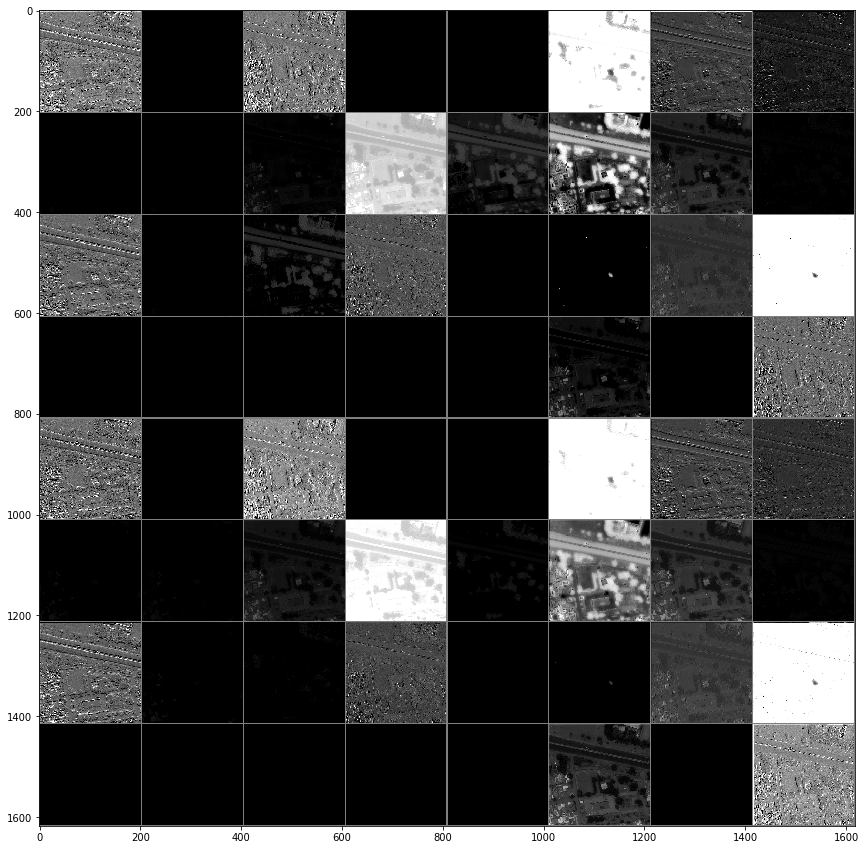

In [14]:
# f0
# f0_m_s_i_s = torch.argmax(f0_m_s_i_s.data, axis=1).type(torch.float32)
# f0_m_s_i_t.shape
f0_m_s_i_t = f0_m_s_i_t.data.permute((1,0,2,3))
f0_m_t_i_t = f0_m_t_i_t.data.permute((1,0,2,3))

# f0_m_s_i_t.shape
batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((f0_m_t_i_t, f0_m_s_i_t), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,15))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


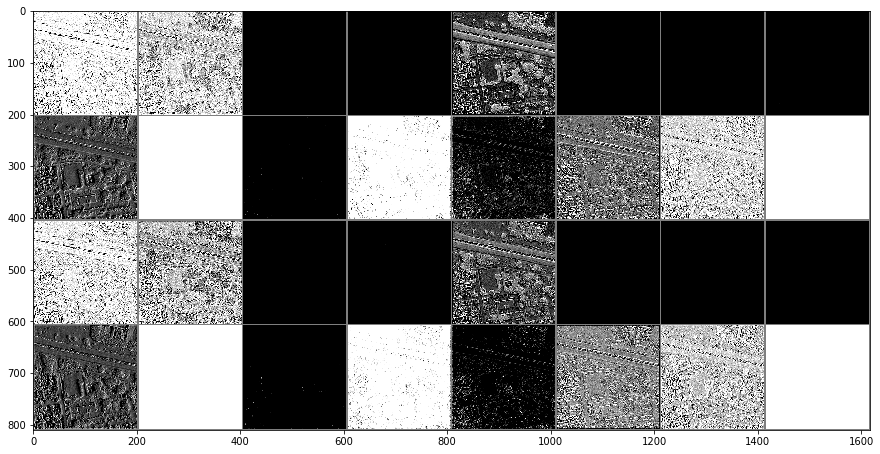

In [15]:
# f1
f1_m_s_i_t = f1_m_s_i_t.data.permute((1,0,2,3))
f1_m_t_i_t = f1_m_t_i_t.data.permute((1,0,2,3))

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((f1_m_t_i_t, f1_m_s_i_t), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,15))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


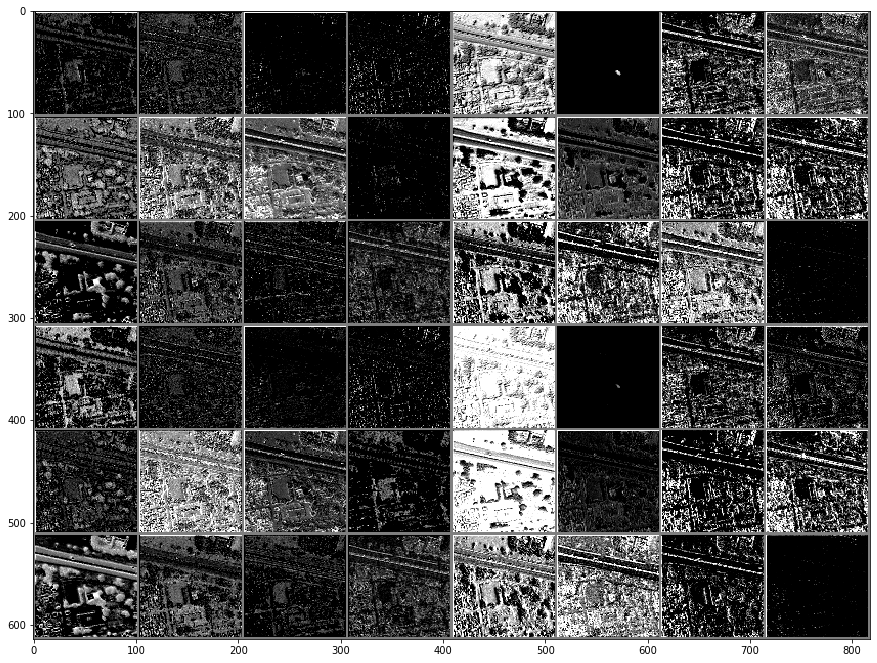

In [16]:
# f2
f2_m_s_i_t = f2_m_s_i_t.data.permute((1,0,2,3))
f2_m_t_i_t = f2_m_t_i_t.data.permute((1,0,2,3))

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((f2_m_t_i_t, f2_m_s_i_t), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,15))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


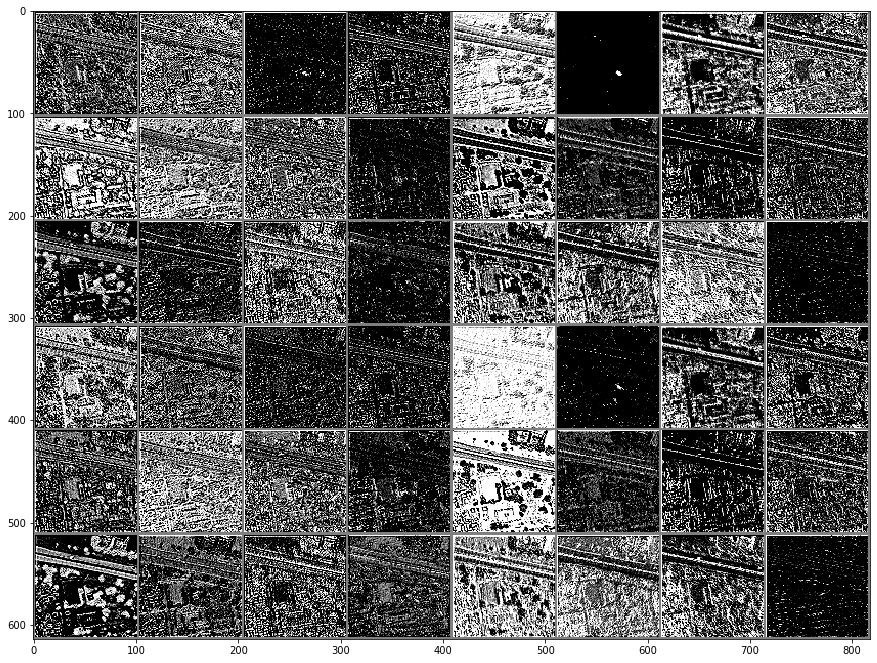

In [17]:
# f3
f3_m_s_i_t = f3_m_s_i_t.data.permute((1,0,2,3))
f3_m_t_i_t = f3_m_t_i_t.data.permute((1,0,2,3))

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((f3_m_t_i_t, f3_m_s_i_t), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,15))
plt.imshow(batch_s1_t2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 320, 25, 25])
torch.Size([320, 1, 25, 25])


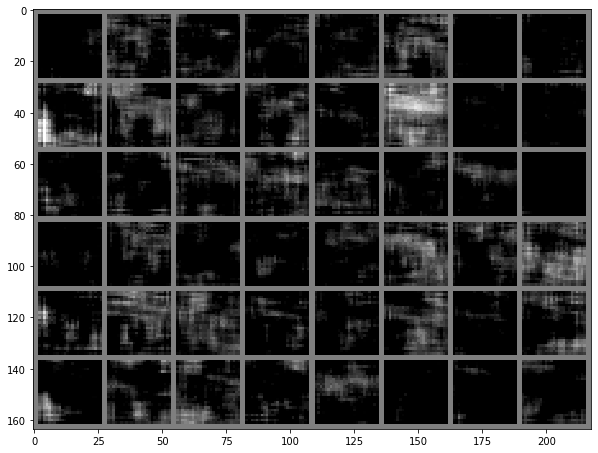

In [26]:
# high_level_feature
print(high_m_t_i_t.shape)
high_m_s_i_t = high_m_s_i_t.data.permute((1,0,2,3))
high_m_t_i_t = high_m_t_i_t.data.permute((1,0,2,3))
print(high_m_t_i_t.shape)

batch_s1_t2 = torchvision.utils.make_grid(
    torch.cat((high_m_t_i_t[:24, :, :, :], high_m_s_i_t[:24,:,:,:]), 0), 
                                        8, pad_value=0.5).cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(10,10))
plt.imshow(batch_s1_t2)
plt.show()